# Attention Visualization

## Step0
Don't forget add @get_local in your model

## Step1 import get_local and activate it BEFORE we import our model

In [1]:
from visualizer import get_local
get_local.activate()

In [2]:
import torch
import torchvision.transforms as T
from timm.models.vision_transformer import vit_small_patch16_224
import json
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

## Step2 define visualization functions

In [3]:
def grid_show(to_shows, cols):
    rows = (len(to_shows)-1) // cols + 1
    it = iter(to_shows)
    fig, axs = plt.subplots(rows, cols, figsize=(rows*8.5, cols*2))
    for i in range(rows):
        for j in range(cols):
            try:
                image, title = next(it)
            except StopIteration:
                image = np.zeros_like(to_shows[0][0])
                title = 'pad'
            axs[i, j].imshow(image)
            axs[i, j].set_title(title)
            axs[i, j].set_yticks([])
            axs[i, j].set_xticks([])
    plt.show()

def visualize_head(att_map):
    ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(att_map)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    plt.show()
    
def visualize_heads(att_map, cols):
    to_shows = []
    att_map = att_map.squeeze()
    for i in range(att_map.shape[0]):
        to_shows.append((att_map[i], f'Head {i}'))
    average_att_map = att_map.mean(axis=0)
    to_shows.append((average_att_map, 'Head Average'))
    grid_show(to_shows, cols=cols)

def gray2rgb(image):
    return np.repeat(image[...,np.newaxis],3,2)
    
def cls_padding(image, mask, cls_weight, grid_size):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
        
    image = np.array(image)

    H, W = image.shape[:2]
    delta_H = int(H/grid_size[0])
    delta_W = int(W/grid_size[1])
    
    padding_w = delta_W
    padding_h = H
    padding = np.ones_like(image) * 255
    padding = padding[:padding_h, :padding_w]
    
    padded_image = np.hstack((padding,image))
    padded_image = Image.fromarray(padded_image)
    draw = ImageDraw.Draw(padded_image)
    draw.text((int(delta_W/4),int(delta_H/4)),'CLS', fill=(0,0,0)) # PIL.Image.size = (W,H) not (H,W)

    mask = mask / max(np.max(mask),cls_weight)
    cls_weight = cls_weight / max(np.max(mask),cls_weight)
    
    if len(padding.shape) == 3:
        padding = padding[:,:,0]
        padding[:,:] = np.min(mask)
    mask_to_pad = np.ones((1,1)) * cls_weight
    mask_to_pad = Image.fromarray(mask_to_pad)
    mask_to_pad = mask_to_pad.resize((delta_W, delta_H))
    mask_to_pad = np.array(mask_to_pad)

    padding[:delta_H,  :delta_W] = mask_to_pad
    padded_mask = np.hstack((padding, mask))
    padded_mask = padded_mask
    
    meta_mask = np.zeros((padded_mask.shape[0], padded_mask.shape[1],4))
    meta_mask[delta_H:,0: delta_W, :] = 1 
    
    return padded_image, padded_mask, meta_mask
    

def visualize_grid_to_grid_with_cls(att_map, grid_index, image, grid_size=14, alpha=0.6):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    attention_map = att_map[grid_index]
    cls_weight = attention_map[0]
    
    mask = attention_map[1:].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    padded_image ,padded_mask, meta_mask = cls_padding(image, mask, cls_weight, grid_size)
    
    if grid_index != 0: # adjust grid_index since we pad our image
        grid_index = grid_index + (grid_index-1) // grid_size[1]
        
    grid_image = highlight_grid(padded_image, [grid_index], (grid_size[0], grid_size[1]+1))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()
    
    ax[0].imshow(grid_image)
    ax[0].axis('off')
    
    ax[1].imshow(grid_image)
    ax[1].imshow(padded_mask, alpha=alpha, cmap='rainbow')
    ax[1].imshow(meta_mask)
    ax[1].axis('off')
    

def visualize_grid_to_grid(att_map, grid_index, image, grid_size=14, alpha=0.6):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    H,W = att_map.shape
    with_cls_token = False
      
    grid_image = highlight_grid(image, [grid_index], grid_size)
    
    mask = att_map[grid_index].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()
    
    ax[0].imshow(grid_image)
    ax[0].axis('off')
    
    ax[1].imshow(grid_image)
    ax[1].imshow(mask/np.max(mask), alpha=alpha, cmap='rainbow')
    ax[1].axis('off')
    plt.show()
    
def highlight_grid(image, grid_indexes, grid_size=14):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    W, H = image.size
    h = H / grid_size[0]
    w = W / grid_size[1]
    image = image.copy()
    for grid_index in grid_indexes:
        x, y = np.unravel_index(grid_index, (grid_size[0], grid_size[1]))
        a= ImageDraw.ImageDraw(image)
        a.rectangle([(y*w,x*h),(y*w+w,x*h+h)],fill =None,outline ='red',width =2)
    return image

## Step3 load image and forawrd

In [4]:
image = Image.open('./assets/dogcat.jpg')

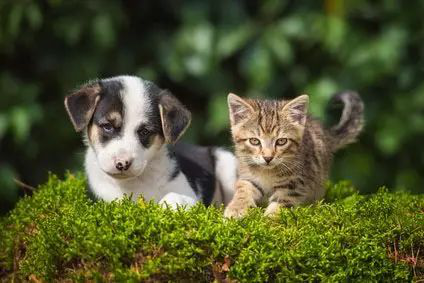

In [5]:
image

In [6]:
imagenet_cls = json.load(open('./imagenet_cls.json'))

In [7]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
transforms = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            normalize,
        ])

In [8]:
input_tensor = transforms(image).unsqueeze(0)
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [9]:
get_local.clear()
with torch.no_grad():
    vit = vit_small_patch16_224(pretrained=True)
    out = vit(input_tensor)
    
print('Top1 prediction:')
print(imagenet_cls[str(out.argmax().item())])

Top1 prediction:
['Border collie']


## Step4 get attention map

In [10]:
cache = get_local.cache
print(list(cache.keys()))

['Attention.forward']


In [11]:
attention_maps = cache['Attention.forward']

### There are 12 attention maps for 12-layer Vit

In [12]:
len(attention_maps)

12

### There are 6 heads each layer

In [13]:
attention_maps[0].shape

(1, 6, 197, 197)

## Step5 show attention map
The red region represents a query. Its attention map is the right picture including CLS token at top left.

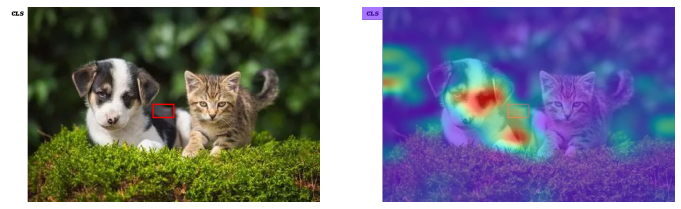

In [39]:
visualize_grid_to_grid_with_cls(attention_maps[4][0,4,:,:], 105, image)

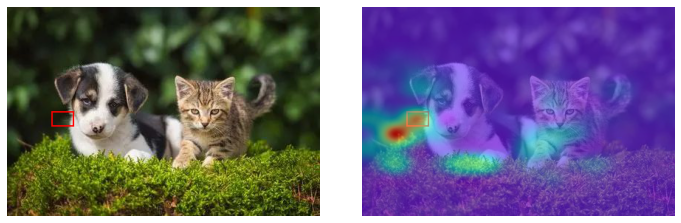

In [15]:
visualize_grid_to_grid(attention_maps[3][0,0,1:,1:], 100, image)

### Attention map of a single head

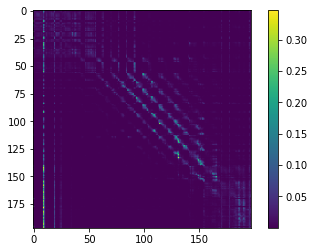

In [41]:
visualize_head(attention_maps[7][0,1])

### Attention maps in layer 1

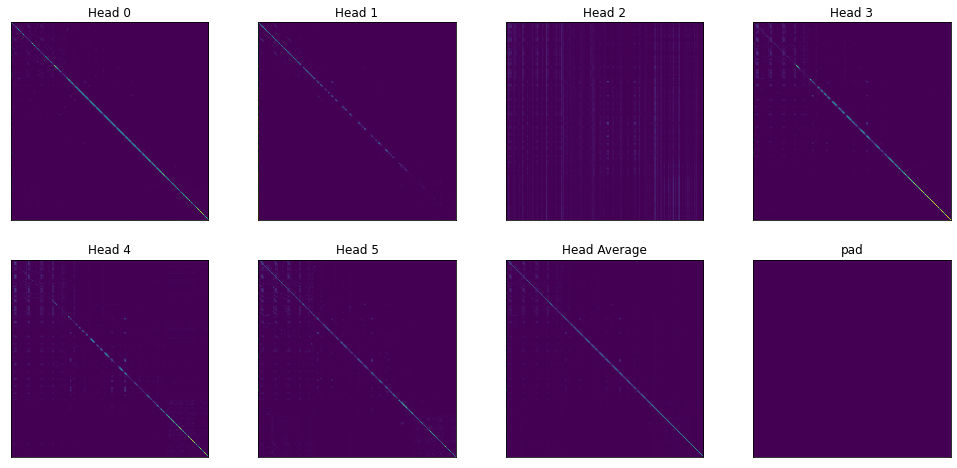

In [17]:
visualize_heads(attention_maps[0], cols=4)

### Attention maps in layer 2

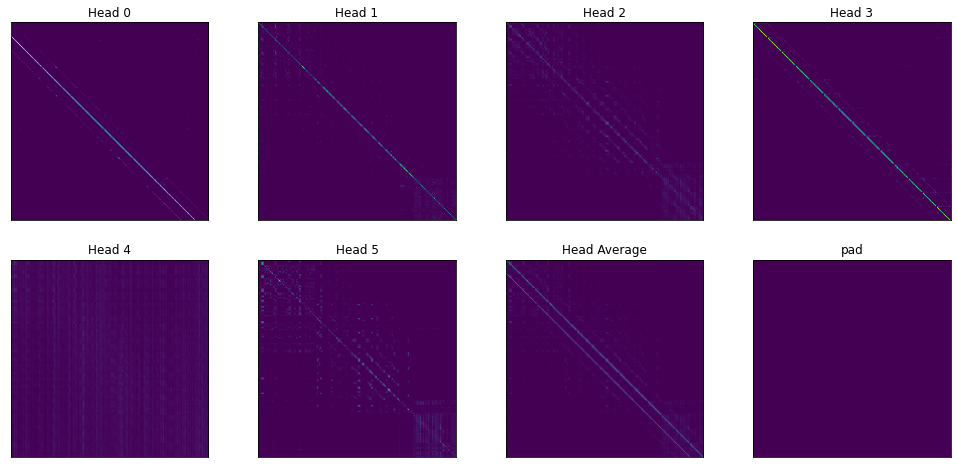

In [18]:
visualize_heads(attention_maps[1], cols=4)

### Attention maps in layer 3

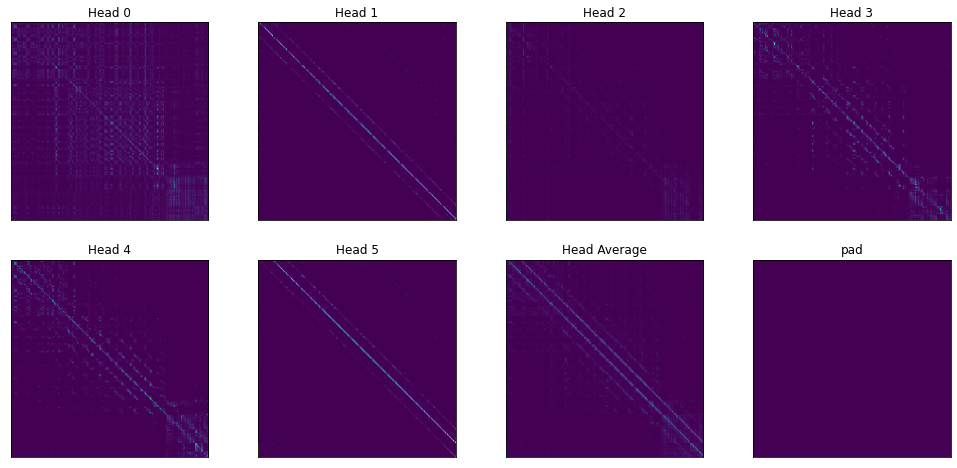

In [19]:
visualize_heads(attention_maps[2], cols=4)

### Attention maps in layer 4

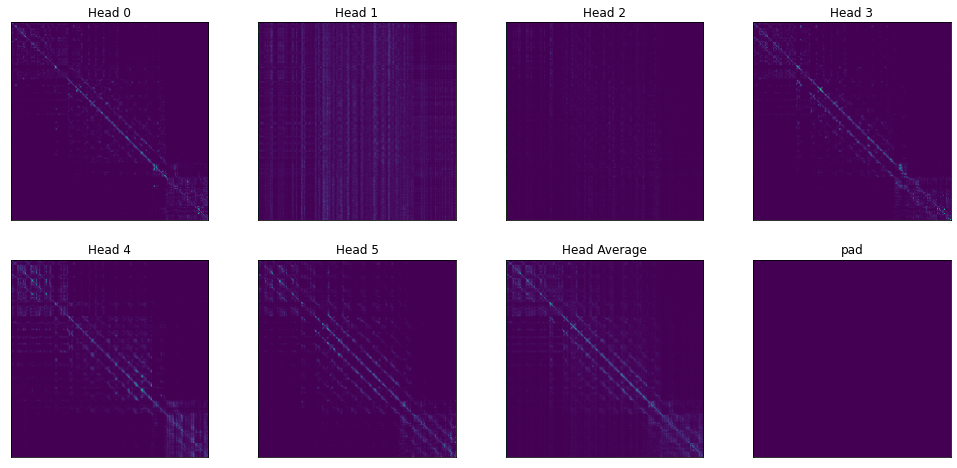

In [20]:
visualize_heads(attention_maps[3], cols=4)

### Attention maps in layer 5

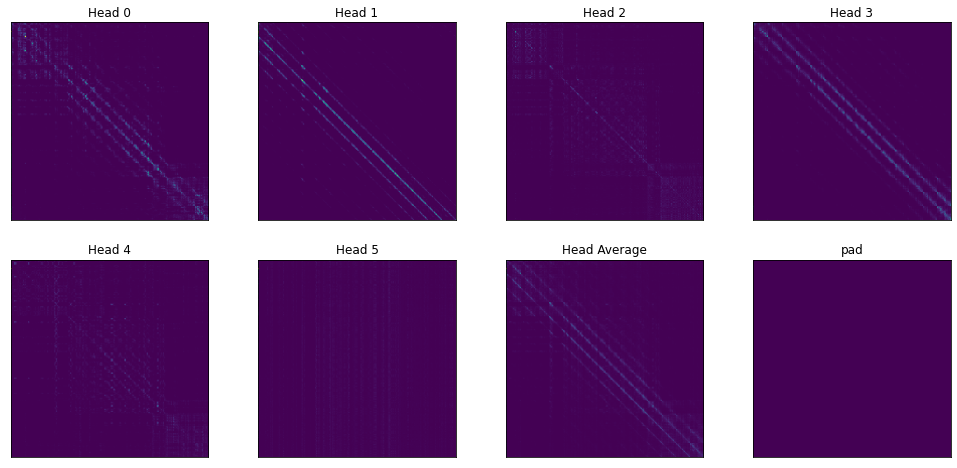

In [21]:
visualize_heads(attention_maps[4], cols=4)

### Attention maps in layer 6

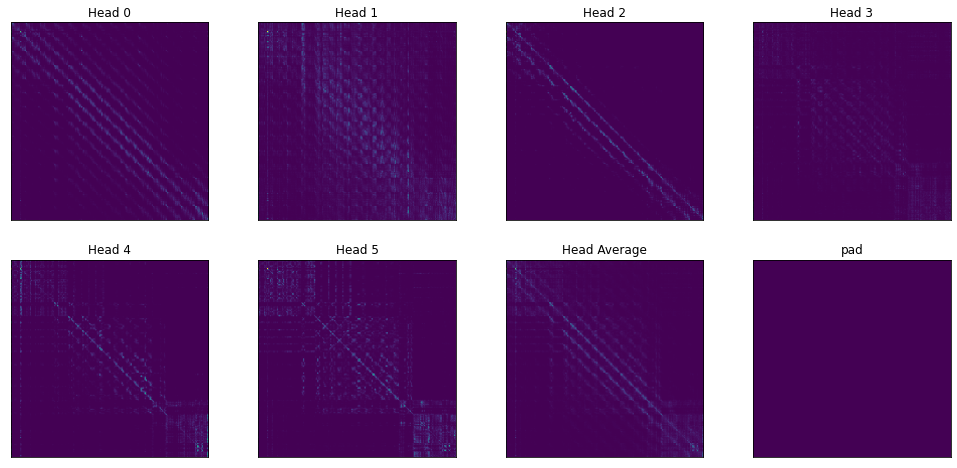

In [22]:
visualize_heads(attention_maps[5], cols=4)

### Attention maps in layer 7

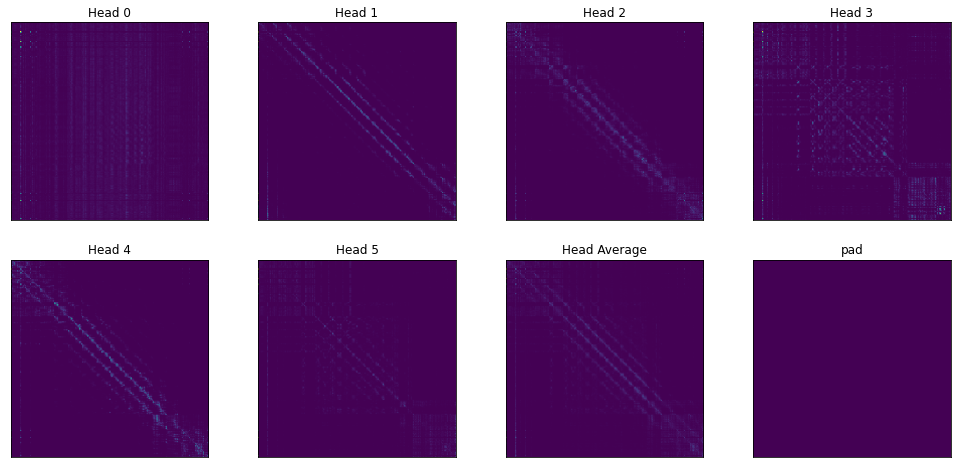

In [23]:
visualize_heads(attention_maps[6], cols=4)

### Attention maps in layer 8

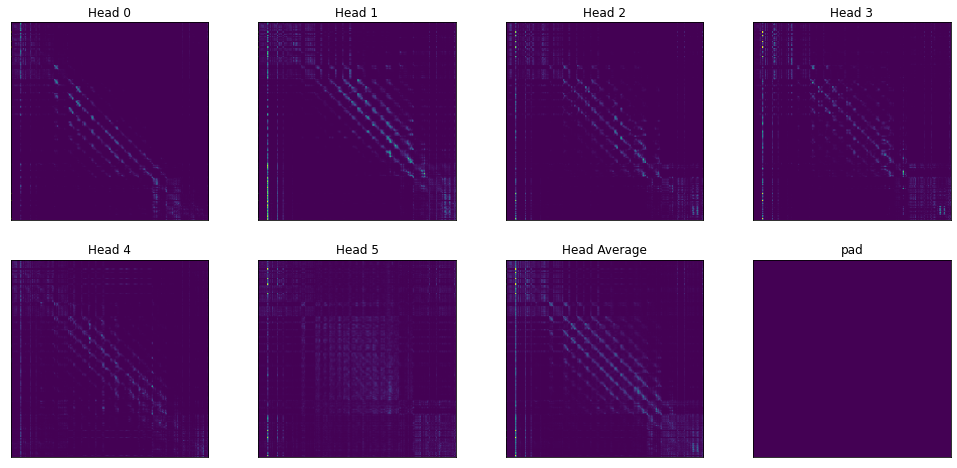

In [24]:
visualize_heads(attention_maps[7], cols=4)

### Attention maps in layer 9

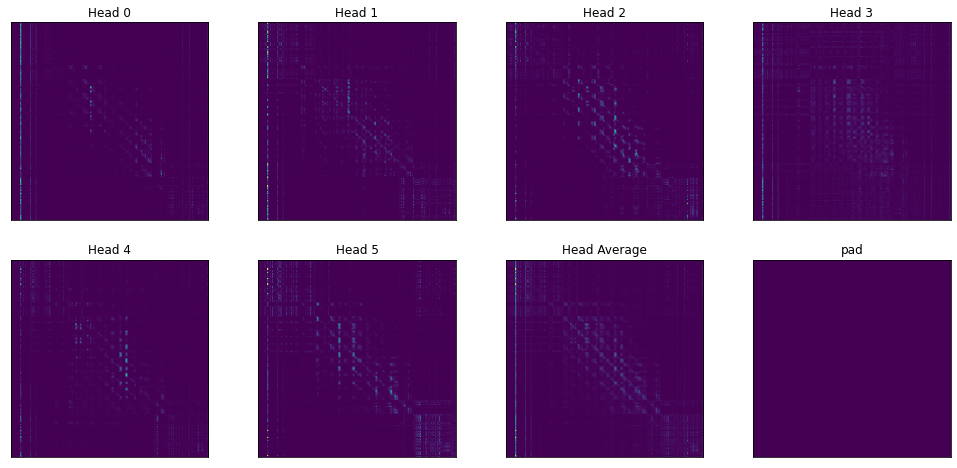

In [25]:
visualize_heads(attention_maps[8], cols=4)

### Attention maps in layer 10

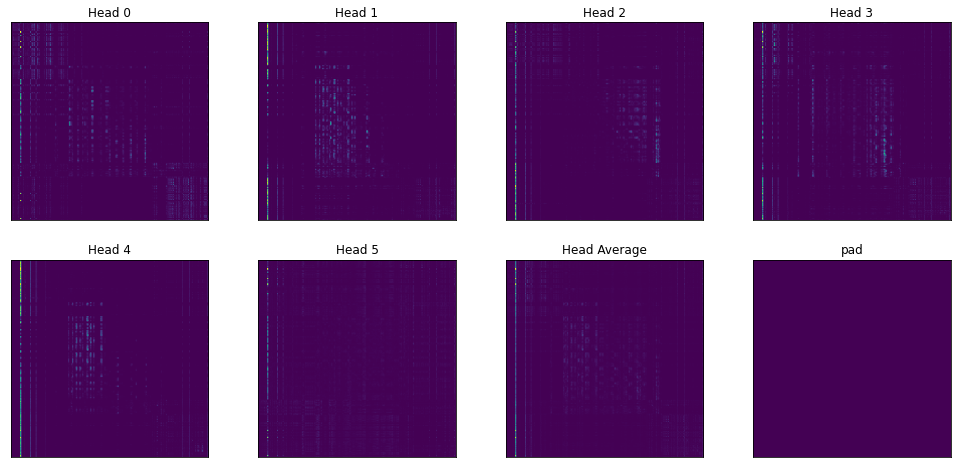

In [26]:
visualize_heads(attention_maps[9], cols=4)

### Attention maps in layer 11

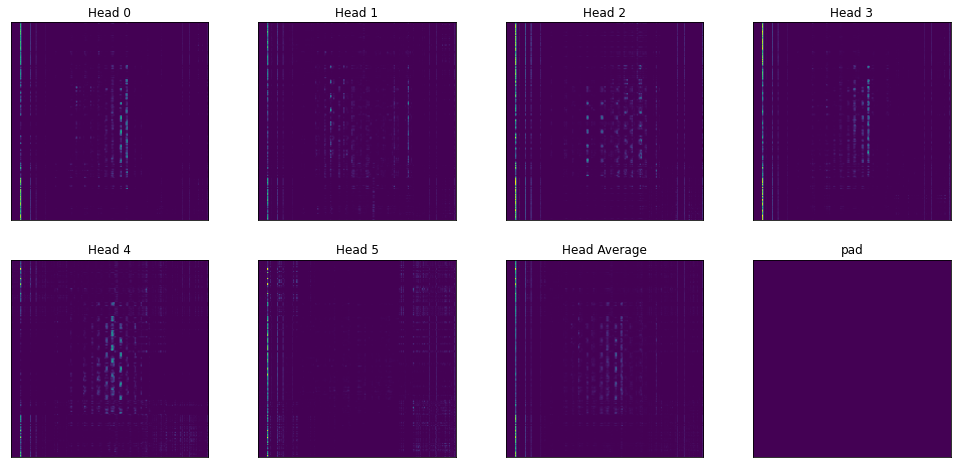

In [27]:
visualize_heads(attention_maps[10], cols=4)

### Attention maps in layer 12

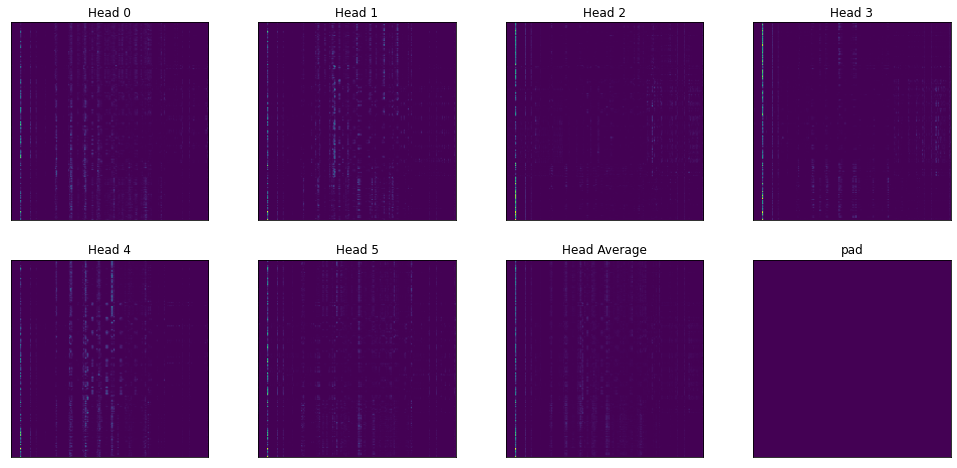

In [28]:
visualize_heads(attention_maps[11], cols=4)